#### Using WEG4\3

Something with low Beta with bovespa

In [1]:
%matplotlib inline

In [2]:
pwd

'/home/andre/Projects/stocks/prototypes'

In [3]:
cd ..

/home/andre/Projects/stocks


In [4]:
%matplotlib inline

In [5]:
from matplotlib import pyplot as plt
import os
import sys
import pandas as pd
import numpy as np
import struct
import datetime
import calendar
import time
import argparse
import seaborn as sns
from algos.util import progressbar
from algos import meta5Ibov
from algos.nn import torchNN, torchCV, torchUtil
import torch as th
import scipy
import talib as ta

In [6]:
cd data

/home/andre/Projects/stocks/data


In [7]:
pwd

'/home/andre/Projects/stocks/data'

In [8]:

import os

if os.name == 'nt':
    meta5Ibov.setDataPath('D:\\Users\\andre.ferreira\\Documents\\stocks\\data', 
                        'D:\\Users\\andre.ferreira\\Documents\\stocks\\data', preload=False)
else:
    meta5Ibov.setDataPath(r'/home/andre/Projects/stocks/data', 
                        r'/home/andre/Projects/stocks/data')

Master data loaded size (minutes):  515198
symbols loaded:
['BBAS3' 'DOL$' 'VALE3' 'ABEV3' 'ITUB4' 'B3SA3' 'BBDC4' 'PETR4' 'WIN@']


In [9]:
meta5Ibov.loadMeta5Data(cleandays=False, preload=False)

symbols loaded:
['BBAS3' 'DOL$' 'VALE3' 'ABEV3' 'ITUB4' 'B3SA3' 'BBDC4' 'WEGE3' 'PETR4'
 'WIN@']
percent missing:  0.057403360195657734


10

In [12]:
win = meta5Ibov.getSymbol('WEGE3')

In [13]:
win['time'] = win.index.map(lambda x: x.time())

In [14]:
win.time.max()

datetime.time(17, 54)

In [15]:
win.isnull().sum().sum() # total number of cells with nans 

0

In [16]:
win.dropna(inplace=True)

Convert to datetime Date

In [17]:
win.head(2)

,O,H,L,C,TV,S,RV,time
time,,,,,,,,
2014-06-30 10:05:00,9.76,9.76,9.76,9.76,2,1,1000,10:05:00
2014-06-30 10:07:00,9.77,9.77,9.77,9.77,1,1,200,10:07:00


In [18]:
win.drop(['TV', 'S'], axis=1, inplace=True)

In [19]:
win['time'] = win.index.map(lambda x: x.time())
win['date'] = win.index.map(lambda x: x.date())

In [20]:
win['hour'] = win.time.apply(lambda x: x.hour)
win['minute'] = win.time.apply(lambda x: x.minute)
win['wday'] = win.date.apply(lambda x: x.weekday()) # week day where Monday is 0 and Sunday is 6
# friday is 4

In [21]:
win.head()

,O,H,L,C,RV,time,date,hour,minute,wday
time,,,,,,,,,,
2014-06-30 10:05:00,9.76,9.76,9.76,9.76,1000,10:05:00,2014-06-30,10,5,0
2014-06-30 10:07:00,9.77,9.77,9.77,9.77,200,10:07:00,2014-06-30,10,7,0
2014-06-30 10:08:00,9.76,9.76,9.76,9.76,200,10:08:00,2014-06-30,10,8,0
2014-06-30 10:09:00,9.76,9.76,9.76,9.76,200,10:09:00,2014-06-30,10,9,0
2014-06-30 10:10:00,9.76,9.76,9.76,9.76,800,10:10:00,2014-06-30,10,10,0


 ### Total number of days

In [22]:
len(win.groupby(win.date)) # days

1249

### We can see the data  market hours were not corrected from summer time

 - ignoring some outliers
 - pre-market is from 9:00 to 10:00 
 - after-market is from 17:00 to 18:00/18:15    
 
 
 - **doesn't matter right now**

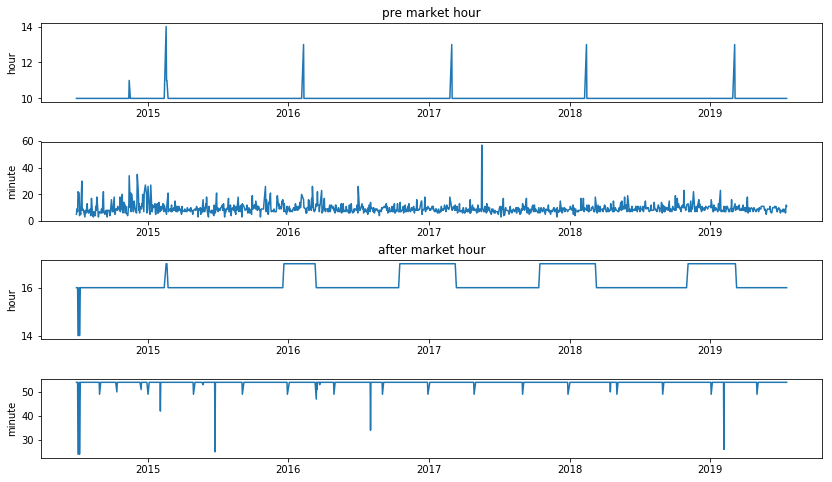

In [23]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(14,8))

ax1.plot(win.groupby(win.date).time.agg(['min']).applymap(lambda x: x.hour))
ax1.set_ylabel('hour')
ax1.set_title('pre market hour')

ax2.plot(win.groupby(win.date).time.agg(['min']).applymap(lambda x: x.minute))
ax2.set_ylabel('minute')


ax3.plot(win.groupby(win.date).time.agg(['max']).applymap(lambda x: x.hour))
ax3.set_ylabel('hour')
ax3.set_title('after market hour')

ax4.plot(win.groupby(win.date).time.agg(['max']).applymap(lambda x: x.minute))
ax4.set_ylabel('minute')

plt.subplots_adjust(hspace=0.5)

### First let's look of days of gaps

 - everyday has a gap

In [24]:
windays = win.groupby(win.date)

In [25]:
windays['C'].agg(['last']).head(3)
#windays['Open'].agg(['first']).head(3)

,last
date,
2014-06-30,9.84
2014-07-01,9.86
2014-07-02,9.79


- Everyday that was not preceeded by its correct week day doesnt have a valid gap or 
- was a holiday 

Since they are few and we have the holidays we  
we will just ignore any incorrect gap

In [26]:
weekfails = np.diff(windays.wday.agg('first'))

In [27]:
weekfails[ (weekfails != -4) & (weekfails != 1) ]

array([ 2,  2,  3,  3, -2, -3,  2, -3,  2,  2,  2, -3, -3, -3, -3, -2, -2,
       -3, -2, -3,  2,  2,  2,  2,  2,  2, -3,  2, -2, -3, -3, -3,  2,  2,
        2,  2,  2, -3, -3, -2,  2, -2, -3,  2,  2, -3, -3, -3, -3,  2,  2,
       -2, -2, -3, -2, -3,  2,  2,  2])

In [28]:
np.count_nonzero(weekfails[ (weekfails != -4) & (weekfails != 1) ])

59

In [29]:
np.count_nonzero(weekfails[ (weekfails != -4) & (weekfails != 1) ])/len(weekfails)

0.047275641025641024

Invalid gaps will certainly be smaller than 4% due holidays

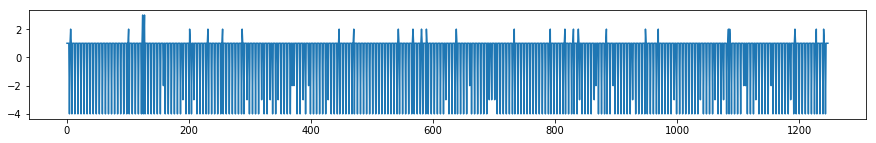

In [30]:
plt.figure(figsize=(15,2))
plt.plot(weekfails)

- Everyday where data started after 9:00 cannot have a valida gap
- Everyday where the day before did not end after 17 hours cannot have a valid gap

In [31]:
hourfails = windays.hour.agg('first').values

In [32]:
hourfails[hourfails != 10]

array([11, 14, 11, 11, 13, 13, 13, 13])

In [33]:
hourfails = windays.hour.agg('last').values

In [34]:
hourfails[hourfails < 16]

array([14, 14])

- We will ignore for now they seam few

In [35]:
# tomorrow open - today's close
# dont have gap on first day that's why [:1] / [:-1]
pclose = windays['C'].agg(['last']).values[:-1] # previous close
open = windays['O'].agg(['first']).values[1:]  
gaps = open-pclose

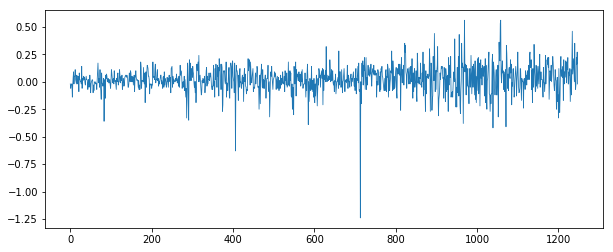

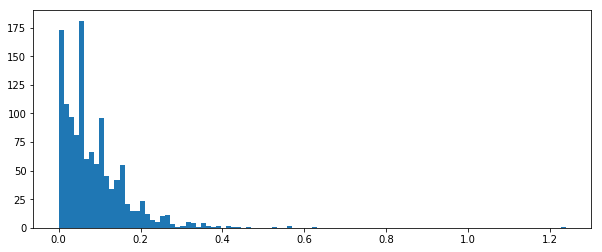

In [36]:
plt.figure(figsize=(10,4))
plt.plot(gaps, lw=0.8)
plt.figure(figsize=(10,4))
plt.hist(abs(gaps), bins=100);

In [37]:
len(gaps[gaps > 0])/len(gaps)

0.5857371794871795

In [38]:
np.percentile(abs(gaps), [90])

array([0.18])

In [39]:
np.percentile(abs(gaps), [10])

array([0.01])

 ### Some conclusions
 
 - 90% of day gaps are smaller than ~.18 cents
 - 90% of days have gaps bigger than ~0.01 cents
 - 58.57% up gaps and rest of down gaps fairly even

## How many gaps close ?

 - Considering even aftermarket hour (query 'hour >= 17')

In [40]:
daymin = windays['H', 'L'].agg(['min', 'max']).min(axis=1)[1:] # first day cannot have gap
daymax = windays['H', 'L'].agg(['min', 'max']).max(axis=1)[1:]
dayshl = np.stack((daymin, daymax), axis=-1)
dayshl[-5:]

array([[22.4 , 23.17],
       [22.42, 22.97],
       [22.48, 22.77],
       [22.63, 22.93],
       [22.71, 22.95]])

Variation in points H and L after openning

In [41]:
varhl = dayshl-open

In [42]:
varhl[-5:]

array([[-0.67,  0.1 ],
       [-0.2 ,  0.35],
       [-0.19,  0.1 ],
       [-0.17,  0.13],
       [-0.02,  0.22]])

In [43]:
gaps[-5:]

array([[-0.02],
       [ 0.22],
       [ 0.16],
       [ 0.27],
       [-0.02]])

In [44]:
gapsign = np.sign(gaps).ravel()
select = gapsign-1
select[select < 0] = 1
select = select.ravel().astype(int)
select

array([1, 1, 1, ..., 0, 0, 1])

Difference between the gap value in points due to an up or down to the corresponding low and high of the day.

In [45]:
gapdif = gaps.ravel() + varhl[np.arange(len(varhl)), select]
gapdif[-5:]

array([ 0.08,  0.02, -0.03,  0.1 ,  0.2 ])

Gap sign

 - 1 means up gap 
 - -1 means down gap

In [46]:
gapsign[-5:]

array([-1.,  1.,  1.,  1., -1.])

Gap results 

  * bigger >= 0 means the gap was closed and even went further that many points
  * smaller < 0 means the gap was not closed and that many points were the distance missing to close

In [47]:
gapresult = gapdif*gapsign*-1

In [48]:
gapresult[-5:]

array([ 0.08, -0.02,  0.03, -0.1 ,  0.2 ])

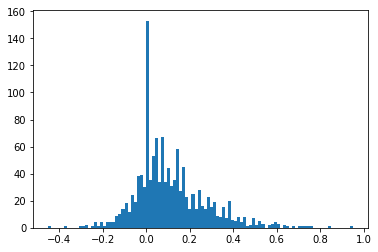

In [49]:
plt.hist(gapresult, bins=100);

In [50]:
len(gapresult[gapresult >=0 ])/len(gapresult)

0.8060897435897436

In [61]:
iselected = np.argwhere( (abs(gaps.ravel()) < 0.10) )
selectedgapresult = gapresult[iselected]
len(selectedgapresult[selectedgapresult >=0 ])/len(selectedgapresult)

0.8842105263157894

In [56]:
iselected = np.argwhere( abs(gaps.ravel()) > 0.57)
selectedgapresult = gapresult[iselected]
1.-(len(selectedgapresult[selectedgapresult >= 0 ])/len(selectedgapresult))

1.0

### Some conclusions
 
 - roughly 80% of gaps close
 - gaps with less than 0.08 cents 91% times close!!
 - gaps with more than 0.57 cents 100% times never close!!

### Make a classifier with Random Forest

Gap will close or not?

- day before above or bellow the moving average of 21D on Close
- day before above or bellow the moving average of 200D on Close
- day before after-market O-H-L-C
- gap-day open price

In [58]:
# plt.figure(figsize=(15,3))
# plt.plot(win.index, win.C)
# plt.plot(win.index, ta.MA(win.C, 21*60*8)) # 21D MA
# plt.plot(win.index, ta.MA(win.C, 200*60*8)) #200D MA